In CUDA-Q, there are 4 ways in which one can execute quantum kernels
1. ```sample```: yields measurement counts
2. ```run```: yields individual return values from multiple executions
3. ```observe```: yields expectation values
4. ```get_state```: yields the quantum statevector of the computation  


Ths most intensive task in the computatiino is the execution of the quantum kernel hence each execution function can be parallelized given access to multiple quantum processing units

# Sample

In [70]:
import cudaq
import numpy as np

qubit_counts = 2

cudaq.set_target('qpp-cpu')

@cudaq.kernel
def kernel(qubit_counts: int):
    qvector = cudaq.qvector(qubit_counts)


    h(qvector[0])
    for i in range(1, qubit_counts):
        x.ctrl(qvector[0], qvector[i])

    mz(qvector)

print(cudaq.draw(kernel, qubit_counts))
result = cudaq.sample(kernel, qubit_counts, shots_count = 3000)
print(result)



     ╭───╮     
q0 : ┤ h ├──●──
     ╰───╯╭─┴─╮
q1 : ─────┤ x ├
          ╰───╯

{ 00:1511 11:1489 }



Inn simulation mode, the quantum state is muilt once and then sampled s times where s equals the ```shots_count```. In hardware execution mode, the quantum state collapses upon measurement and hence needs to be reuilt over and over again

## Sample Asynchronous  
One can parallelize over various kernels, variational parameters or even distribute shots counts over multiple QPUs

In [4]:
result_async = cudaq.sample_async(kernel, qubit_counts, shots_count=1000)
print(result_async.get())

{ 00:518 11:482 }



# Run  
The ```run``` executes a quantum kernel multiple times and returns each individual result. It preserves each individual return value unlike ```sample```

In [7]:
@cudaq.kernel
def kernel(num_qubits: int)->int:
    qubits = cudaq.qvector(num_qubits)

    h(qubits[0])

    for i in range(1, num_qubits):
        x.ctrl(qubits[0], qubits[i])

    result = 0
    for i in range(num_qubits):
        if mz(qubits[i]) == 1:
            result += 1

    return result

num_qubits = 3
results = cudaq.run(kernel, num_qubits, shots_count=20)

print(f"Executed {len(results)} shots")
print(f"Results: {results}")
print(f"Possible values: Either 0 or {num_qubits} due to GHZ state properties")

# Count occurrences of each result
value_counts = {}
for value in results:
    value_counts[value] = value_counts.get(value, 0) + 1

print("\nCounts of each result:")
for value, count in value_counts.items():
    print(f"{value}: {count} times")

Executed 20 shots
Results: [0, 3, 0, 0, 0, 3, 3, 3, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0]
Possible values: Either 0 or 3 due to GHZ state properties

Counts of each result:
0: 13 times
3: 7 times


## Return Custom Data Type  
It allows returning multiple values from your quantum computation in a structured way

In [16]:
from dataclasses import dataclass

# Define a custom `dataclass` to return from our quantum kernel
@dataclass(slots=True)
class MeasurementResult:
    first_qubit: bool
    last_qubit: bool
    total_ones: int

@cudaq.kernel
def bell_pair() -> MeasurementResult:
    qubits = cudaq.qvector(2)
    h(qubits[0])
    x.ctrl(qubits[0], qubits[1])

    first_meas = mz(qubits[0])
    last_meas = mz(qubits[1])

    total = 0 
    if first_meas == 1:
        total += 1
    if last_meas == 1:
        total += 1

    return MeasurementResult(first_meas, last_meas, total)

results = cudaq.run(bell_pair, shots_count = 10)

print("Individual measurement results:")
for i, res in enumerate(results):
    print(
        f"Shot {i}: {{{res.first_qubit}, {res.last_qubit}}}\ttotal ones={res.total_ones}" # {{는 {를 출력함
    )

# Verify the Bell state correlations
correlated_count = sum(
    1 for res in results if res.first_qubit == res.last_qubit)
print(
    f"\nCorrelated measurements: {correlated_count}/{len(results)} ({correlated_count/len(results)*100:.1f}%)"
)

Individual measurement results:
Shot 0: {True, True}	total ones=2
Shot 1: {True, True}	total ones=2
Shot 2: {False, False}	total ones=0
Shot 3: {True, True}	total ones=2
Shot 4: {False, False}	total ones=0
Shot 5: {False, False}	total ones=0
Shot 6: {True, True}	total ones=2
Shot 7: {True, True}	total ones=2
Shot 8: {False, False}	total ones=0
Shot 9: {True, True}	total ones=2

Correlated measurements: 10/10 (100.0%)


## Run Asynchronous

In [47]:
@cudaq.kernel
def simple(angle:float)->int:
    q = cudaq.qubit()
    ry(angle, q)
    return int(mz(q))


figures = []
angles = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]

for i, angle in enumerate(angles):
    result = cudaq.run_async(simple, angle, shots_count=10)
    figures.append(result)

for i, future in enumerate(figures):
    results = future.get()
    ones_count = sum(results)
    print(f"Angle {angles[i]:.1f}: {ones_count}/10 ones measured")

Angle 0.0: 0/10 ones measured
Angle 0.2: 0/10 ones measured
Angle 0.4: 2/10 ones measured
Angle 0.6: 1/10 ones measured
Angle 0.8: 4/10 ones measured
Angle 1.0: 5/10 ones measured
Angle 1.2: 2/10 ones measured
Angle 1.4: 5/10 ones measured


# Observe

In [72]:
from cudaq import spin

hamil = spin.z(0) + spin.y(1) + spin.x(0) * spin.z(0)

@cudaq.kernel
def kernel(n_qubits: int):
    qubits = cudaq.qvector(n_qubits)
    h(qubits[0])

    for i in range(1, n_qubits):
        x.ctrl(qubits[0], qubits[i])

result = cudaq.observe(kernel, hamil, 2).expectation()
print("<H> =", result)

<H> = 0.0


## Observe Asynchronous

In [73]:
# Define a quantum kernel function.
@cudaq.kernel
def kernel1(qubit_count: int):
    qvector = cudaq.qvector(qubit_count)

    # 2-qubit GHZ state.
    h(qvector[0])
    for i in range(1, qubit_count):
        x.ctrl(qvector[0], qvector[i])


# Measuring the expectation value of 2 different Hamiltonians in parallel
hamiltonian_1 = spin.x(0) + spin.y(1) + spin.z(0) * spin.y(1)

# Asynchronous execution on multiple `qpus` via `nvidia` `gpus`.
result_1 = cudaq.observe_async(kernel1, hamiltonian_1, 2, qpu_id= 0)

# Retrieve results
print(result_1.get().expectation())

1.1102230246251565e-16


# Get State  
It gives us access to the quantum statevector of the computation. It is only feasible in simulation mode

In [63]:
result = cudaq.get_state(kernel, 2)
print(result)
print(type(result))
print(np.array(result))

(0.707107,0)
       (0,0)
       (0,0)
(0.707107,0)

<class 'cudaq.mlir._mlir_libs._quakeDialects.cudaq_runtime.State'>
[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


The statevector generated by the ```get_state``` command follows Bing-endian convention for associating numbers with their binary representation, which places the least significant bit on the **left**. That is, for the example of a 2-bit system, we have the following translation b/w integers and bits:  
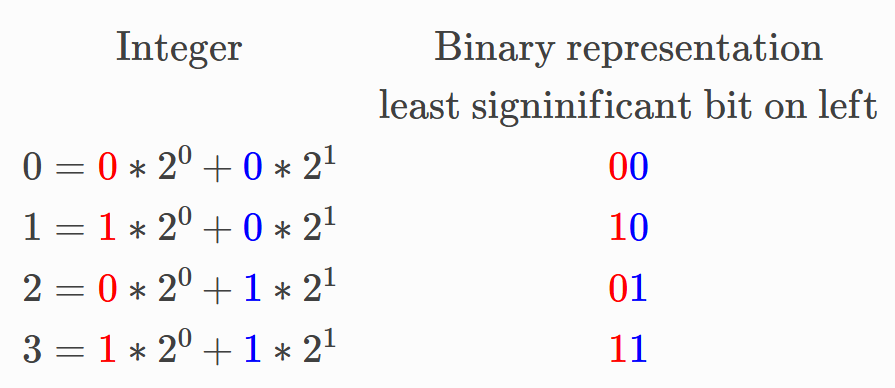  

## Get State Asynchronous

In [ ]:
@cudaq.kernel
def bell_state():
    q = cudaq.qvector(2)
    h(q[0])
    x.ctrl(q[0], q[1])
    

state_feature = cudaq.get_state_async(bell_state)

print("Computing state asynchronously...")

state = state_feature.get()
print('Bell state vector:')
print(np.array(state))

Computing state asynchronously...
Bell state vector:
[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
